In [1]:
from sklearn.model_selection import train_test_split
from transformers import (
    BertTokenizer,
    BertForSequenceClassification,
    Trainer,
    TrainingArguments
)
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import torch

/home/vlad/Code/DataMining/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from datasets import load_dataset
dataset = load_dataset("ag_news")

In [3]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=4)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [4]:
def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True, max_length=128)

tokenized = dataset.map(tokenize_function, batched=True)
tokenized = tokenized.rename_column("label", "labels")
tokenized.set_format("torch", columns=["input_ids", "attention_mask", "labels"])

train_dataset = tokenized["train"].shuffle(seed=10).select(range(200))
test_dataset  = tokenized["test"].select(range(100))

In [5]:
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average="weighted")
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "precision": precision, "recall": recall, "f1": f1}

In [6]:
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=2,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    learning_rate=2e-4,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=5,
)

In [48]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics
)
trainer.train()
results = trainer.evaluate()
trainer.save_model("./topic_model")
history = trainer.state.log_history

Step,Training Loss
5,0.962300
10,0.413100
15,0.571000
20,0.320300
25,0.324000
30,0.175200
35,0.183800
40,0.245400
45,0.340200
50,0.239700


In [59]:
print(results)

{'eval_loss': 0.9126827120780945, 'eval_accuracy': 0.79, 'eval_precision': 0.8646857142857144, 'eval_recall': 0.79, 'eval_f1': 0.795990338164251, 'eval_runtime': 0.217, 'eval_samples_per_second': 460.885, 'eval_steps_per_second': 59.915, 'epoch': 2.0}


In [33]:
model = BertForSequenceClassification.from_pretrained("./topic_model")
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

In [39]:
labels = ["Finance", "Sport", "Medicine", "Science"]

In [40]:
def classify_text(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=128)
    with torch.no_grad():
        outputs = model(**inputs)
    predicted_class = torch.argmax(outputs.logits, dim=1).item()
    print(f"Text: {text}")
    print(f"Topic: {labels[predicted_class]}")

In [41]:
classify_text("Fly to the moon today")

Text: Fly to the moon today
Topic: Science


In [42]:
classify_text("Manchester is best in football!!!")

Text: Manchester is best in football!!!
Topic: Sport


In [44]:
import matplotlib.pyplot as plt
import pandas as pd

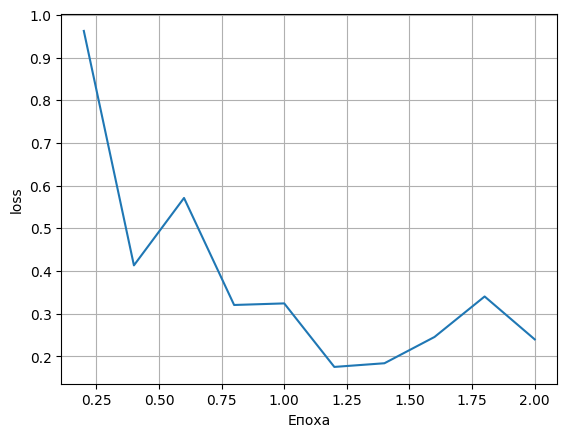

In [60]:
logs = pd.DataFrame(trainer.state.log_history)
if "loss" in logs.columns:
    plt.plot(logs["epoch"], logs["loss"])

plt.xlabel("Епоха")
plt.ylabel("loss")
plt.grid(True)
plt.show()